In [1]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [59]:
data = pd.read_csv('../../Data/Processed/Climate_data.csv')

IRS_data = pd.read_csv('../../Data/Processed/time_features.csv')

In [ ]:
data.head()

IRS_data.head()

,date,meantemp,humidity,wind_speed,meanpressure,Year,Month,Day,Weekday
0,2013-01-01,0.122271,0.840372,0.000000,0.132603,0.0,0.0,0.000000,0.166667
1,2013-01-02,0.042795,0.929054,0.070583,0.132881,0.0,0.0,0.033333,0.333333
2,2013-01-03,0.035662,0.869932,0.109743,0.132994,0.0,0.0,0.066667,0.500000
3,2013-01-04,0.081514,0.684685,0.029212,0.132799,0.0,0.0,0.100000,0.666667
4,2013-01-05,0.000000,0.867962,0.087636,0.132712,0.0,0.0,0.133333,0.833333


In [86]:
train = data[:-180]
test = data[-180:]
print(train.shape)
print(test.shape)

IRS_train = IRS_data[:-180]
IRS_test = IRS_data[-180:]

print(IRS_train.shape)
print(IRS_test.shape)

(1395, 9)
(180, 9)
(1395, 12)
(180, 12)


In [88]:
x_train = train.drop(columns = {'date','meantemp'}, axis = 1)
y_train = train.loc[:, ['meantemp']]


IRS_x_train = IRS_train.drop(columns = {'date','meantemp'}, axis = 1)
IRS_y_train = IRS_train.loc[:, ['meantemp']]

x_test = test.drop(columns = {'date','meantemp'}, axis = 1)
y_test = test.loc[:, ['meantemp']]

IRS_x_test = IRS_test.drop(columns = {'date','meantemp'}, axis = 1)
IRS_y_test = IRS_test.loc[:, ['meantemp']]

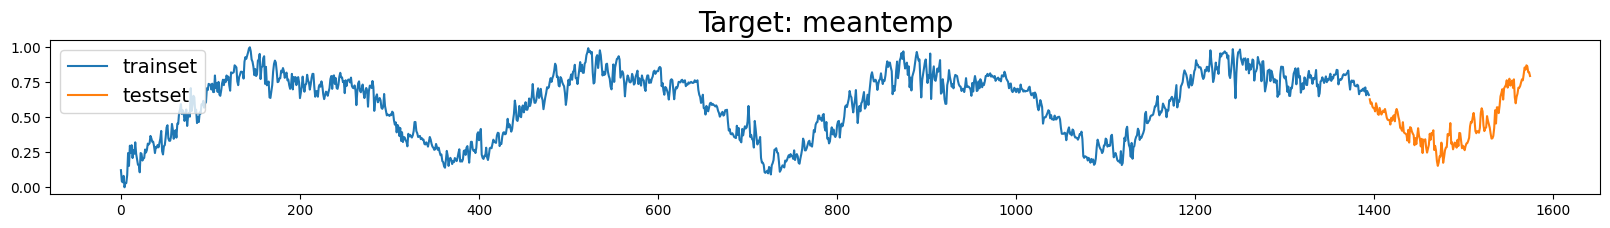

In [89]:
sns.reset_orig()
plt.figure(figsize = (20,2))
plt.title('Target: meantemp', fontsize = 20)
plt.plot(y_train['meantemp'], label = 'trainset')
plt.plot(y_test['meantemp'], label = 'testset')

plt.legend(fontsize = 14)
plt.show()

# LightGBM

In [90]:
import lightgbm as lgb

In [91]:
# train the lightGBM model
model = lgb.LGBMRegressor().fit(x_train, y_train)

pred = model.predict(x_test)

# R^2
r2 = r2_score(pred, y_test)
mse = mean_squared_error(pred, y_test)
print('R2: ', r2, '  ;  ', 'MSE: ', mse)

IRS_model = lgb.LGBMRegressor().fit(IRS_x_train, IRS_y_train)

IRS_pred = IRS_model.predict(IRS_x_test)
IRS_r2 = r2_score(IRS_pred, IRS_y_test)
IRS_mse = mean_squared_error(IRS_pred, IRS_y_test)
print('R2: ', IRS_r2, '  ;  ', 'MSE: ', IRS_mse)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 815
[LightGBM] [Info] Number of data points in the train set: 1395, number of used features: 7
[LightGBM] [Info] Start training from score 0.603260
R2:  0.7814408856481162   ;   MSE:  0.008271250694535643
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2033
[LightGBM] [Info] Number of data points in the train set: 1395, number of used features: 10
[LightGBM] [Info] Start training from score 25.735216
R2:  0.9240135606609905   ;   MSE:  2.3857900263103673


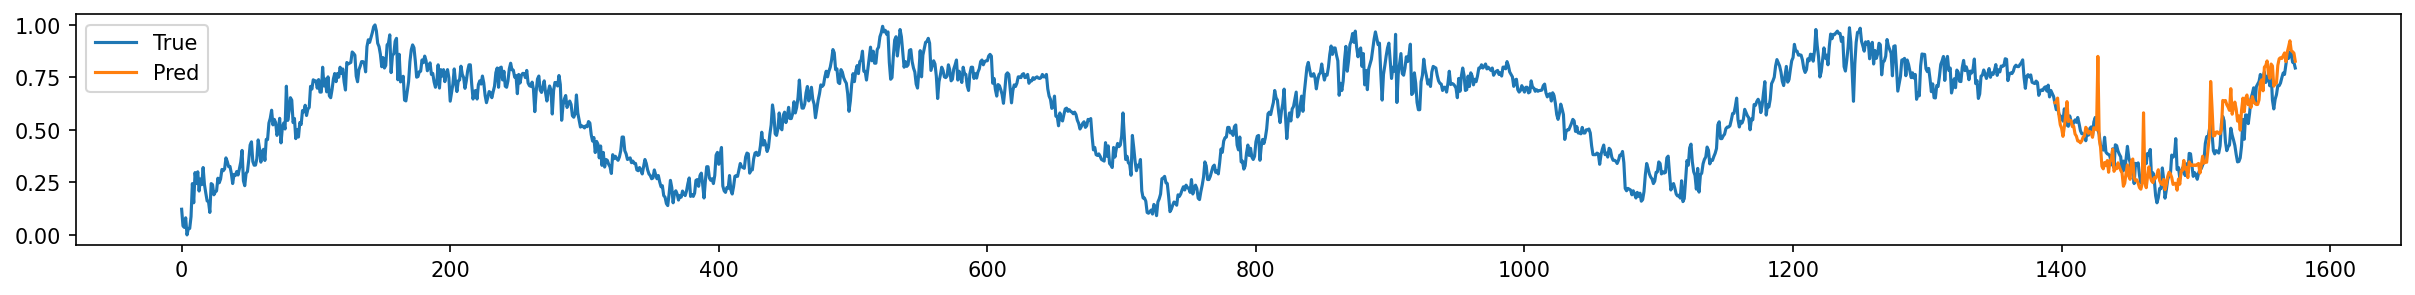

In [93]:
prediction = pd.DataFrame(pred, index=y_test.index)

sns.reset_orig()
plt.figure(figsize = (20,2), dpi=150)

plt.plot(data['meantemp'], label = 'True')
plt.plot(prediction, label = 'Pred')

plt.legend()

plt.show()

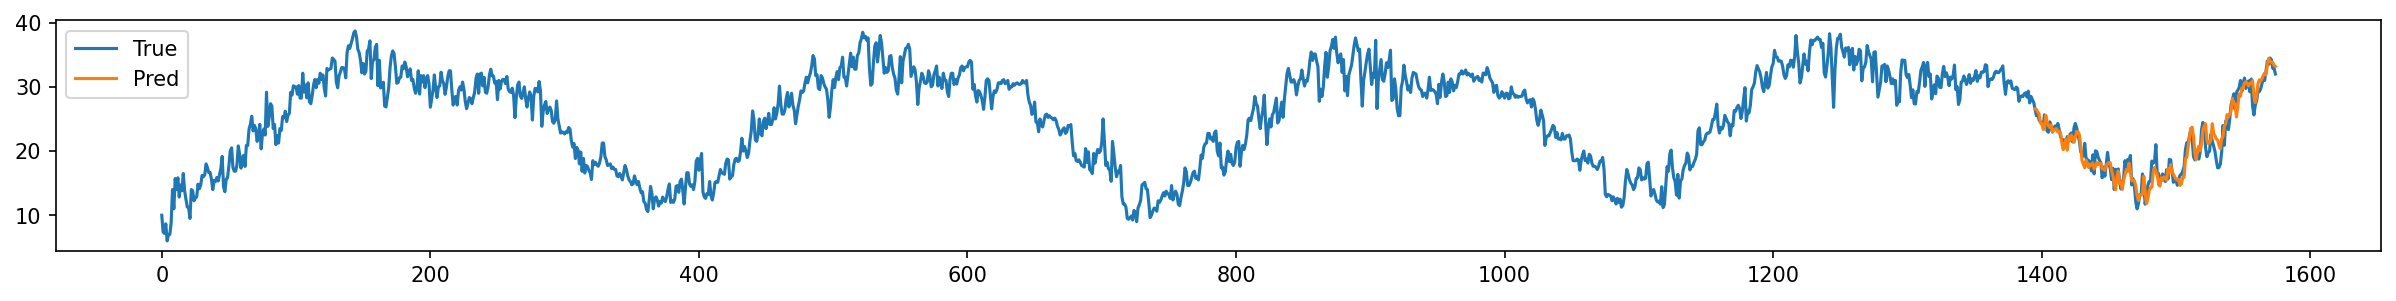

In [99]:
IRS_prediction = pd.DataFrame(IRS_pred, index=IRS_y_test.index)

sns.reset_orig()
plt.figure(figsize = (20,2), dpi=150)

plt.plot(IRS_data['meantemp'], label = 'True')
plt.plot(IRS_prediction, label = 'Pred')

plt.legend()

plt.show()

# Interpretation of LightGBM

In [100]:
import ShapTimeBoosting
from ShapTimeBoosting import supertime, ShapleyValues, TimeImportance, TimeHeatmap

In [101]:
# The training set is evenly divided into 8 parts in the time dimension, 
# and the importance of each part is calculated.
Tn= 8

interp_x= x_train
IRS_interp_x = IRS_x_train
model = model

IRS_model = IRS_model

# a list of 8 Shapley values per SHAPTime definition
# one for each time chunk out of 8
ShapTime_lgb = ShapleyValues(model, interp_x, Tn)



In [102]:
ShapTime_lgb

[np.float64(-0.012461220892220334),
 np.float64(0.003985234530871604),
 np.float64(-0.041053474239185615),
 np.float64(0.03391227164457228),
 np.float64(-0.05451358583048289),
 np.float64(0.046430979020581936),
 np.float64(-0.0464967784101408),
 np.float64(0.0712799978148201)]

In [103]:
# name these time periods
time_columns =  ['t0', 't1', 't2', 't3', 't4', 't5', 't6', 't7']

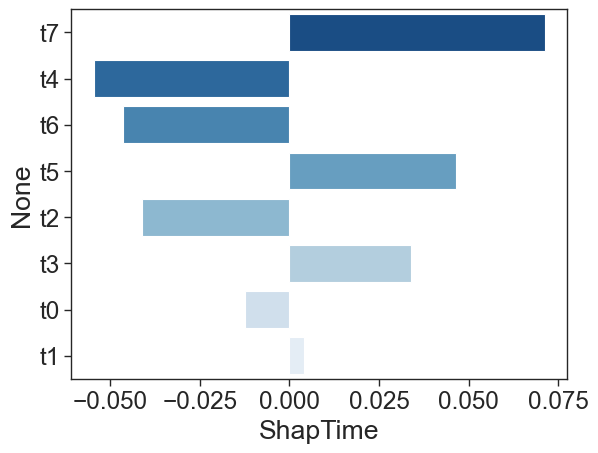

In [104]:
# Time importance is just the author-defined 
# code that provides this plot
TimeImportance(Tn, ShapTime_lgb, time_columns)

In [110]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap

def TimeImportanceEncoded(model, x_data, time_features, time_columns, Tn=8, time_column=None):
    """
    Compute and plot temporal importance using standard SHAP values
    for only time-related features, aggregated over Tn intervals,
    keeping the sign (positive/negative) to mirror SHAPTime plot.

    Parameters
    ----------
    model : trained LightGBM model
    x_data : pd.DataFrame, includes all features used for prediction
    time_features : list of column names that encode temporal info
    time_columns : list of names for the time intervals (length Tn)
    Tn : int, number of time intervals to split
    time_column : str, optional, column representing time for grouping rows
    """
    
    x_data = x_data.copy()
    
    # 1️⃣ Create time intervals
    n = len(x_data)
    if time_column is None:
        x_data['time_group'] = pd.qcut(range(n), q=Tn, labels=False)
    else:
        x_data['time_group'] = pd.qcut(x_data[time_column], q=Tn, labels=False)
    
    # 2️⃣ Compute SHAP values for all features
    feature_cols = [c for c in x_data.columns if c != 'time_group']
    explainer = shap.TreeExplainer(model)
    shap_values_all = explainer.shap_values(x_data[feature_cols])
    
    # Convert to DataFrame
    shap_df_all = pd.DataFrame(shap_values_all, columns=feature_cols)
    
    # 3️⃣ Keep only time-related features for aggregation
    shap_df_time = shap_df_all[time_features].copy()
    shap_df_time['time_group'] = x_data['time_group']
    
    # 4️⃣ Aggregate SHAP values per time interval, keeping sign
    interval_importance = shap_df_time.groupby('time_group').mean().mean(axis=1)
    
    # 5️⃣ Prepare DataFrame for plotting
    plot_df = pd.DataFrame({'ShapTime': interval_importance.values})
    
    # Assign user-provided interval names
    if len(time_columns) != Tn:
        raise ValueError("Length of time_columns must equal Tn")
    plot_df.index = time_columns
    
    # Sort by ShapTime (optional)
    plot_df.sort_values(by='ShapTime', inplace=True)
    
    # 6️⃣ Plot (horizontal barplot, signed)
    sns.set(context='paper', style='ticks', font_scale=2)
    ax = sns.barplot(
        x="ShapTime",
        y=plot_df.index,
        data=plot_df,
        orient='h',
        color="lightskyblue",
        palette='Blues_r'
    )
    ax.set_xlabel("SHAP Value (Temporal Importance)")
    ax.set_ylabel("Time Interval")
    plt.show()
    
    return plot_df


In [112]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap

def TimeImportanceTraditionalSHAP(model, x_data, time_columns, Tn=8, time_column=None):
    """
    Compute and plot temporal importance using traditional SHAP
    for the SAME model used with SHAPTime (no time-encoded features),
    by aggregating feature-level SHAP values over Tn time intervals.

    Parameters
    ----------
    model : trained LightGBM model (same one used for SHAPTime)
    x_data : pd.DataFrame, features used to train that model
    time_columns : list of names for the time intervals (length Tn)
    Tn : int, number of time intervals to split
    time_column : str, optional, column representing time for grouping rows
                  If None, row order is used.
    """

    x_data = x_data.copy()

    # 1️⃣ Create time intervals (same idea as SHAPTime)
    n = len(x_data)
    if time_column is None:
        x_data['time_group'] = pd.qcut(range(n), q=Tn, labels=False)
    else:
        x_data['time_group'] = pd.qcut(x_data[time_column], q=Tn, labels=False)

    # 2️⃣ Compute traditional SHAP values for ALL features
    #    (must match training features exactly)
    feature_cols = [c for c in x_data.columns if c != 'time_group']
    explainer = shap.TreeExplainer(model)
    shap_values_all = explainer.shap_values(x_data[feature_cols])

    # Put SHAP values in a DataFrame
    shap_df_all = pd.DataFrame(shap_values_all, columns=feature_cols)
    shap_df_all['time_group'] = x_data['time_group']

    # 3️⃣ Aggregate SHAP per time interval (keep sign)
    #    → mean over rows in interval, then mean over features
    interval_importance = (
        shap_df_all
        .groupby('time_group')
        .mean()           # avg SHAP per feature in each interval
        .mean(axis=1)     # avg across all features
    )

    # 4️⃣ Build DataFrame in the same style as original TimeImportance
    if len(time_columns) != Tn:
        raise ValueError("Length of time_columns must equal Tn")

    shapley_impor = pd.DataFrame(index=range(Tn), columns=['ShapTime'])
    shapley_impor['ShapTime'] = interval_importance.values
    shapley_impor['absolute'] = shapley_impor['ShapTime'].abs()

    # Set readable interval labels
    shapley_impor.index = time_columns

    # Sort by absolute magnitude (like original SHAPTime plot)
    shapley_impor.sort_values(by='absolute', inplace=True, ascending=False)

    # 5️⃣ Plot (same visual style as SHAPTime)
    sns.set(context='paper', style='ticks', font_scale=2)
    ax = sns.barplot(
        x="ShapTime",
        y=shapley_impor.index,
        data=shapley_impor,
        orient='h',
        color="lightskyblue",
        palette='Blues_r'
    )
    ax.set_xlabel("SHAP Value (Traditional SHAP, aggregated by time interval)")
    ax.set_ylabel("Time Interval")
    plt.show()

    return shapley_impor


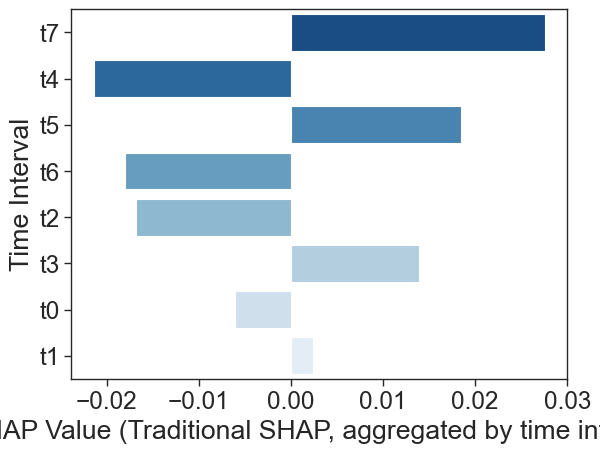

In [114]:
time_columns = ["t0","t1","t2","t3","t4","t5","t6","t7"]

traditional_shap_time_imp = TimeImportanceTraditionalSHAP(
    model,
    x_train,   # the data WITHOUT encoded time features
    time_columns,
    Tn=8,
    time_column=None  # or None if you just use row order
)

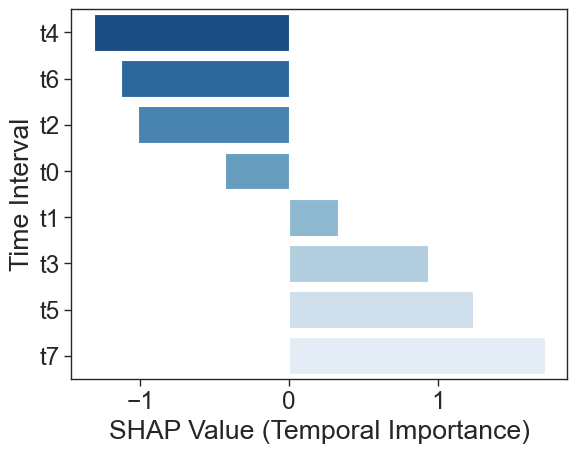

In [111]:
time_features = ["meantemp_lag_1","meantemp_roll_mean_7d","meantemp_roll_mean_30d"]  # your time features

plot_df = TimeImportanceEncoded(IRS_model, IRS_x_train, time_features, time_columns, Tn=8, time_column=None)


In [ ]:
time_features = ['lag_1_temp', 'lag_2_temp', 'rolling_7', 'month', 'day_of_year']  # your time features
time_columns = ["Interval 1","Interval 2","Interval 3","Interval 4",
                "Interval 5","Interval 6","Interval 7","Interval 8"]  # names for the 8 intervals

plot_df = TimeImportanceEncoded(model, x_train, time_features, time_columns, Tn=8, time_column='date')


In [56]:
TimeHeatmap(Tn, ShapTime_lgb, time_columns)

# Evaluation of Interpretation

### Feature-Independence

In [16]:
import EvaluationBoosting
from ShapTimeBoosting import FeaIndepenVal, PlotVal

In [17]:
n = 3
Tn = 8
x_train_val = x_train.copy()
y_train = y_train
initial = ShapTime_lgb
model = lgb.LGBMRegressor()

In [18]:
result = FeaIndepenVal(x_train_val, y_train, initial, model, Tn, n, time_columns)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 1395, number of used features: 6
[LightGBM] [Info] Start training from score 0.603260
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 305
[LightGBM] [Info] Number of data points in the train set: 1395, number of used features: 5
[LightGBM] [Info] Start training from score 0.603260
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 305
[LightGBM] [Info] Number of data points in the train set: 1395, number of used features: 5
[LightGBM] [Info] Start training fro

In [19]:
result

,t0,t1,t2,t3,t4,t5,t6,t7
0,-0.012461,0.003985,-0.041053,0.033912,-0.054514,0.046431,-0.046497,0.071280
1,-0.012922,0.004410,-0.041105,0.033334,-0.053869,0.045953,-0.046726,0.071962
2,-0.012420,0.004069,-0.040990,0.033152,-0.054192,0.046415,-0.046788,0.071797
3,-0.012857,0.004517,-0.040368,0.032927,-0.054575,0.046440,-0.047240,0.072243


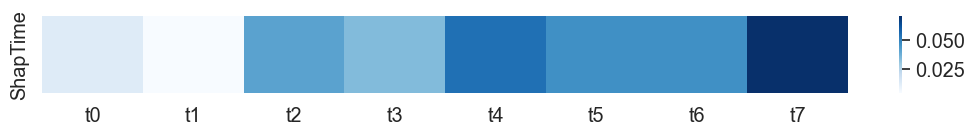

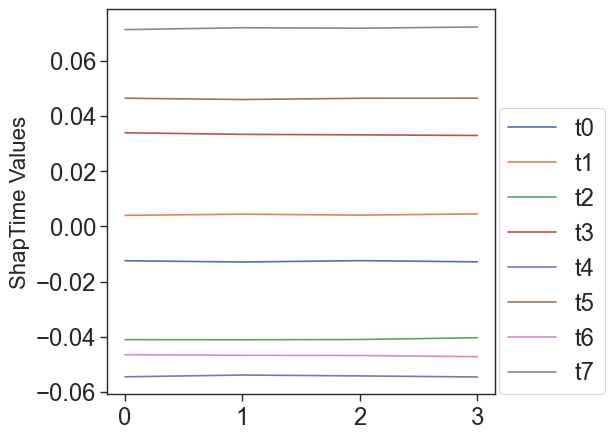

In [20]:
PlotVal(result)

### Sensitivity

In [21]:
situation_0 = [0, 1, 2, 3, 4, 5, 6, 7]
situation_1 = [0, 1, 2, 3, 4, 5, 6, 1]
situation_2 = [0, 1, 2, 3, 0, 5, 6, 1]

In [22]:
total = [situation_0, situation_1, situation_2]
train_eva = train.drop(columns = 'date')
df_eva = supertime(8, train_eva)
model_eva = lgb.LGBMRegressor()

In [23]:
import EvaluationBoosting
from EvaluationBoosting import evaluation, R2Plot, MSEPlot

In [24]:
r2_results, mse_results = evaluation(df_eva, x_train, y_train, 'meantemp', model_eva, total)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 814
[LightGBM] [Info] Number of data points in the train set: 1392, number of used features: 7
[LightGBM] [Info] Start training from score 0.604416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 813
[LightGBM] [Info] Number of data points in the train set: 1392, number of used features: 7
[LightGBM] [Info] Start training from score 0.581498
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 813
[LightGBM] [Info] Number of data points in the train set: 1392, number of used features: 7
[LightGBM] [Info] Start training fro

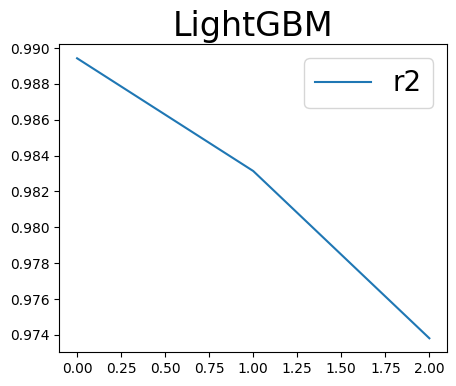

In [25]:
R2Plot(r2_results, 'LightGBM')

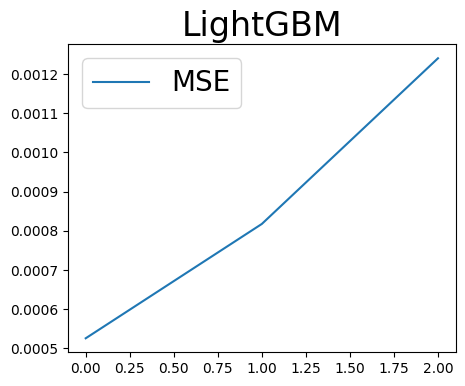

In [26]:
MSEPlot(mse_results, 'LightGBM')

# Improvement

In [27]:
for k in range(Tn):
    exec(f't{k} = supertime(Tn, train)[k]')

In [28]:
check_replist = [t0, t7, t2, t3, t4, t5, t6, t7]

In [29]:
#check
check = pd.concat(check_replist, axis = 0)
x_check = check.drop(columns = {'date','meantemp'}, axis = 1)
y_check = check.loc[:, ['meantemp']]

model_check = lgb.LGBMRegressor().fit(x_check, y_check)

pred_check = model_check.predict(x_test)
r2_check = r2_score(pred_check, y_test)
mse_check = mean_squared_error(pred_check, y_test)

print(r2_check, 'Degree of Improvement: {:.2%}'.format((r2_check-r2)/abs(r2)))
print(mse_check, 'Degree of Improvement: {:.2%}'.format((mse-mse_check)/mse))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 815
[LightGBM] [Info] Number of data points in the train set: 1392, number of used features: 7
[LightGBM] [Info] Start training from score 0.627333
0.7847757866392302 Degree of Improvement: 0.43%
0.008232901303202485 Degree of Improvement: 0.46%
0.7847757866392302 Degree of Improvement: 0.43%
0.008232901303202485 Degree of Improvement: 0.46%


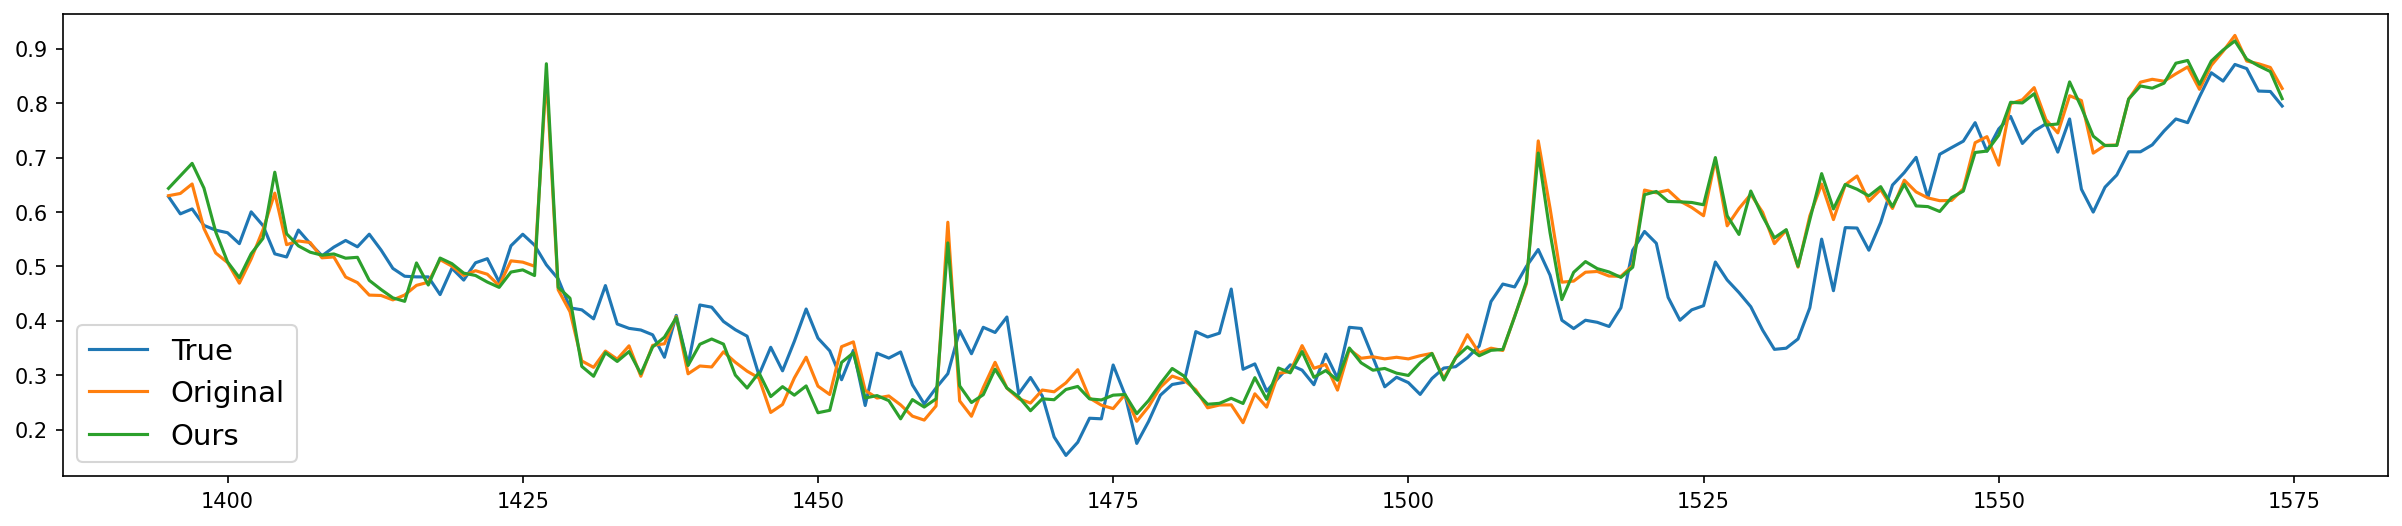

In [30]:
pred_our = pd.DataFrame(pred_check, index=y_test.index)

sns.reset_orig()
plt.figure(figsize = (20,4), dpi=150)

plt.plot(y_test['meantemp'], label = 'True')
plt.plot(prediction, label = 'Original')
plt.plot(pred_our, label = 'Ours')

plt.legend(fontsize = 14)
plt.show()

# wee replace orange one just w our data

# Time-Enhanced Dataset Analysis

Applying the complete ShapTime methodology to the time-enhanced dataset with rich temporal features.

In [31]:
# Load time-enhanced dataset
data_enhanced = pd.read_csv('../../Data/Processed/time_features.csv')
data_enhanced.head()

,date,meantemp,humidity,wind_speed,meanpressure,month,year,sin_dayofyear,cos_dayofyear,meantemp_lag_1,meantemp_roll_mean_7d,meantemp_roll_mean_30d
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667,1,2013,0.017166,0.999853,NaN,NaN,NaN
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000,1,2013,0.034328,0.999411,10.000000,10.000000,10.000000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667,1,2013,0.051479,0.998674,7.400000,8.700000,8.700000
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667,1,2013,0.068615,0.997643,7.166667,8.188889,8.188889
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000,1,2013,0.085731,0.996318,8.666667,8.308333,8.308333


In [32]:
# Data split for time-enhanced dataset
train_enhanced = data_enhanced[:-180]
test_enhanced = data_enhanced[-180:]
print("Enhanced train shape:", train_enhanced.shape)
print("Enhanced test shape:", test_enhanced.shape)

Enhanced train shape: (1395, 12)
Enhanced test shape: (180, 12)


In [33]:
# Prepare features for time-enhanced model (handle NaN values)
# Drop date column and fill any NaN values
train_clean = train_enhanced.drop(columns=['date']).fillna(method='ffill').fillna(method='bfill')
test_clean = test_enhanced.drop(columns=['date']).fillna(method='ffill').fillna(method='bfill')

x_train_enh = train_clean.drop(columns={'meantemp'}, axis=1)
y_train_enh = train_clean.loc[:, ['meantemp']]

x_test_enh = test_clean.drop(columns={'meantemp'}, axis=1)
y_test_enh = test_clean.loc[:, ['meantemp']]

print("Enhanced features:", x_train_enh.columns.tolist())

Enhanced features: ['humidity', 'wind_speed', 'meanpressure', 'month', 'year', 'sin_dayofyear', 'cos_dayofyear', 'meantemp_lag_1', 'meantemp_roll_mean_7d', 'meantemp_roll_mean_30d']


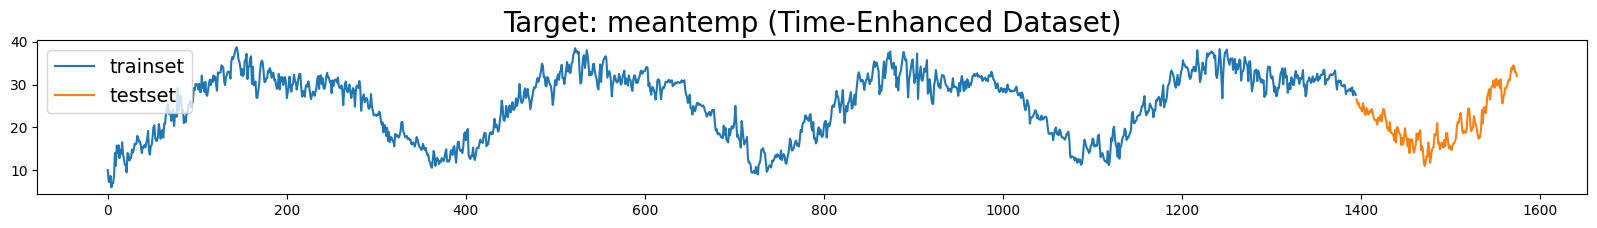

In [34]:
# Visualize enhanced dataset
sns.reset_orig()
plt.figure(figsize = (20,2))
plt.title('Target: meantemp (Time-Enhanced Dataset)', fontsize = 20)
plt.plot(y_train_enh['meantemp'], label = 'trainset')
plt.plot(y_test_enh['meantemp'], label = 'testset')

plt.legend(fontsize = 14)
plt.show()

# LightGBM on Time-Enhanced Dataset

In [35]:
# Train LightGBM on enhanced features
model_enh = lgb.LGBMRegressor().fit(x_train_enh, y_train_enh)

pred_enh = model_enh.predict(x_test_enh)
r2_enh = r2_score(pred_enh, y_test_enh)
mse_enh = mean_squared_error(pred_enh, y_test_enh)

print('Enhanced Dataset - R2: ', r2_enh, '  ;  ', 'MSE: ', mse_enh)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2033
[LightGBM] [Info] Number of data points in the train set: 1395, number of used features: 10
[LightGBM] [Info] Start training from score 25.735216
Enhanced Dataset - R2:  0.92833979306493   ;   MSE:  2.2959335698883026
Enhanced Dataset - R2:  0.92833979306493   ;   MSE:  2.2959335698883026


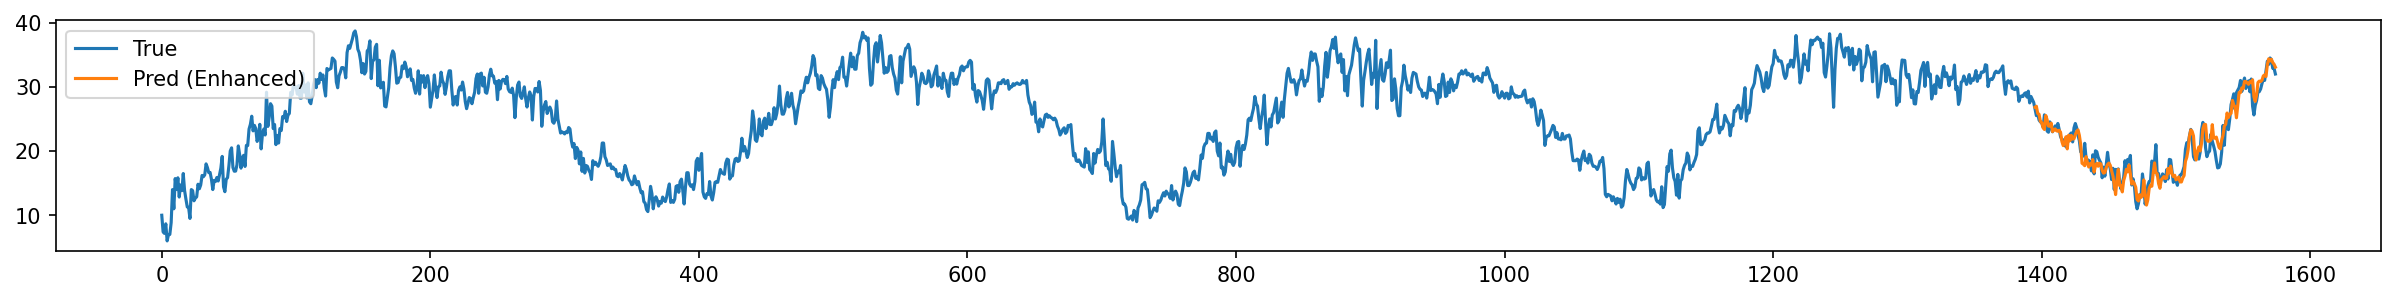

In [36]:
# Visualize enhanced model predictions
prediction_enh = pd.DataFrame(pred_enh, index=y_test_enh.index)

sns.reset_orig()
plt.figure(figsize = (20,2), dpi=150)

plt.plot(data_enhanced['meantemp'], label = 'True')
plt.plot(prediction_enh, label = 'Pred (Enhanced)')

plt.legend()
plt.show()

# Interpretation of Enhanced LightGBM

In [37]:
# ShapTime analysis on enhanced dataset
Tn_enh = 8
interp_x_enh = x_train_enh
model_enh = model_enh

ShapTime_lgb_enh = ShapleyValues(model_enh, interp_x_enh, Tn_enh)

In [38]:
ShapTime_lgb_enh

[np.float64(-0.41151755675599094),
 np.float64(0.13530815275347716),
 np.float64(-1.3335645429203784),
 np.float64(1.1150716283047382),
 np.float64(-1.7972241920260026),
 np.float64(1.5227408443379706),
 np.float64(-1.5365014250277267),
 np.float64(2.343392844201583)]

In [39]:
# Time period names for enhanced dataset
time_columns_enh = ['t0_enh', 't1_enh', 't2_enh', 't3_enh', 't4_enh', 't5_enh', 't6_enh', 't7_enh']

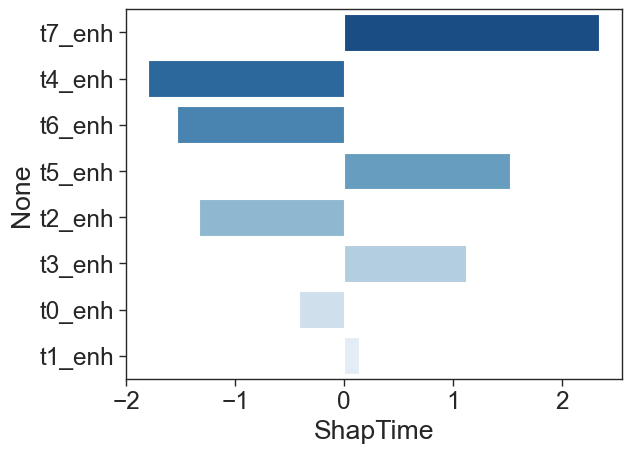

In [40]:
TimeImportance(Tn_enh, ShapTime_lgb_enh, time_columns_enh)

In [41]:
TimeHeatmap(Tn_enh, ShapTime_lgb_enh, time_columns_enh)

# Evaluation of Enhanced Dataset Interpretation

### Feature-Independence (Enhanced)

In [42]:
# Feature independence evaluation for enhanced dataset
n_enh = 3
Tn_enh = 8
x_train_val_enh = x_train_enh.copy()
y_train_enh_val = y_train_enh
initial_enh = ShapTime_lgb_enh
model_enh_val = lgb.LGBMRegressor()

In [43]:
result_enh = FeaIndepenVal(x_train_val_enh, y_train_enh_val, initial_enh, model_enh_val, Tn_enh, n_enh, time_columns_enh)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1778
[LightGBM] [Info] Number of data points in the train set: 1395, number of used features: 9
[LightGBM] [Info] Start training from score 25.735216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1523
[LightGBM] [Info] Number of data points in the train set: 1395, number of used features: 8
[LightGBM] [Info] Start training from score 25.735216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1523
[LightGBM] [Info] Number of data points in the train set: 1395, number of used features: 8
[LightGBM] [Info] Start trainin

In [44]:
result_enh

,t0_enh,t1_enh,t2_enh,t3_enh,t4_enh,t5_enh,t6_enh,t7_enh
0,-0.411518,0.135308,-1.333565,1.115072,-1.797224,1.522741,-1.536501,2.343393
1,-0.406052,0.142221,-1.328016,1.087974,-1.778994,1.518704,-1.547374,2.348949
2,-0.401758,0.141382,-1.334239,1.090171,-1.780583,1.520285,-1.545574,2.347534
3,-0.416581,0.145524,-1.326418,1.088221,-1.784073,1.523188,-1.542141,2.349257


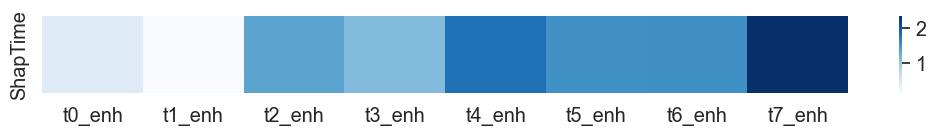

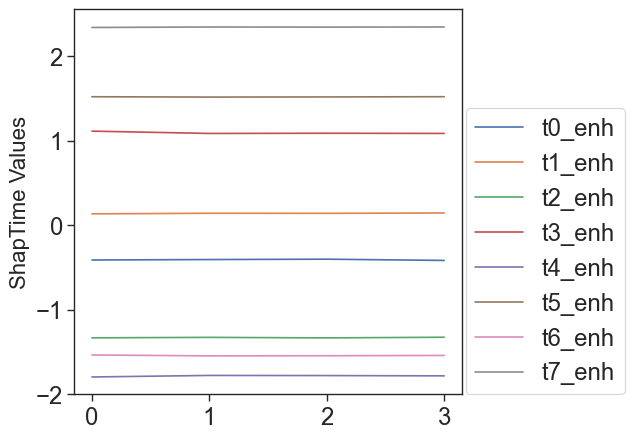

In [45]:
PlotVal(result_enh)

### Sensitivity (Enhanced)

In [46]:
# Sensitivity analysis for enhanced dataset
situation_0_enh = [0, 1, 2, 3, 4, 5, 6, 7]
situation_1_enh = [0, 1, 2, 3, 4, 5, 6, 1]
situation_2_enh = [0, 1, 2, 3, 0, 5, 6, 1]

In [47]:
total_enh = [situation_0_enh, situation_1_enh, situation_2_enh]
train_eva_enh = train_clean
df_eva_enh = supertime(8, train_eva_enh)
model_eva_enh = lgb.LGBMRegressor()

In [48]:
r2_results_enh, mse_results_enh = evaluation(df_eva_enh, x_train_enh, y_train_enh, 'meantemp', model_eva_enh, total_enh)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2033
[LightGBM] [Info] Number of data points in the train set: 1392, number of used features: 10
[LightGBM] [Info] Start training from score 25.773032
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2039
[LightGBM] [Info] Number of data points in the train set: 1392, number of used features: 10
[LightGBM] [Info] Start training from score 25.023301
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2039
[LightGBM] [Info] Number of data points in the train set: 1392, number of used features: 10
[LightGBM] [Info] Start trai

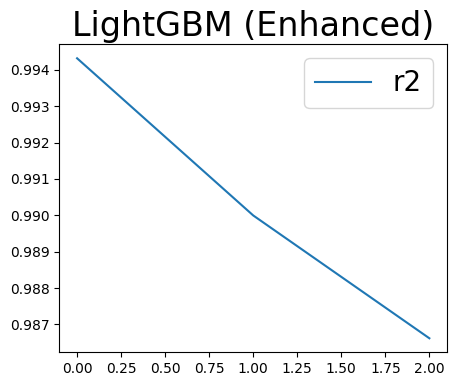

In [49]:
R2Plot(r2_results_enh, 'LightGBM (Enhanced)')

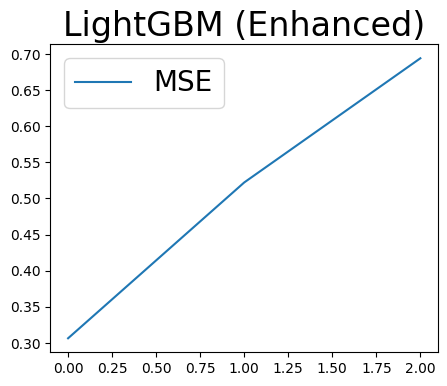

In [50]:
MSEPlot(mse_results_enh, 'LightGBM (Enhanced)')

# Improvement (Enhanced Dataset)

In [51]:
# Generate time periods for enhanced dataset
for k in range(Tn_enh):
    exec(f't{k}_enh = supertime(Tn_enh, train_clean)[k]')

In [52]:
# Create improved model based on ShapTime insights for enhanced dataset
# Use the most important time periods identified by ShapTime
check_replist_enh = [t0_enh, t7_enh, t2_enh, t3_enh, t4_enh, t5_enh, t6_enh, t7_enh]

In [53]:
# Train improved model on enhanced dataset
check_enh = pd.concat(check_replist_enh, axis = 0)
x_check_enh = check_enh.drop(columns = {'meantemp'}, axis = 1)
y_check_enh = check_enh.loc[:, ['meantemp']]

model_check_enh = lgb.LGBMRegressor().fit(x_check_enh, y_check_enh)

pred_check_enh = model_check_enh.predict(x_test_enh)
r2_check_enh = r2_score(pred_check_enh, y_test_enh)
mse_check_enh = mean_squared_error(pred_check_enh, y_test_enh)

print("Enhanced Dataset Results:")
print(r2_check_enh, 'Degree of Improvement: {:.2%}'.format((r2_check_enh-r2_enh)/abs(r2_enh)))
print(mse_check_enh, 'Degree of Improvement: {:.2%}'.format((mse_enh-mse_check_enh)/mse_enh))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2024
[LightGBM] [Info] Number of data points in the train set: 1392, number of used features: 10
[LightGBM] [Info] Start training from score 26.522762
Enhanced Dataset Results:
0.9266222217545278 Degree of Improvement: -0.19%
2.3462752568295064 Degree of Improvement: -2.19%
Enhanced Dataset Results:
0.9266222217545278 Degree of Improvement: -0.19%
2.3462752568295064 Degree of Improvement: -2.19%


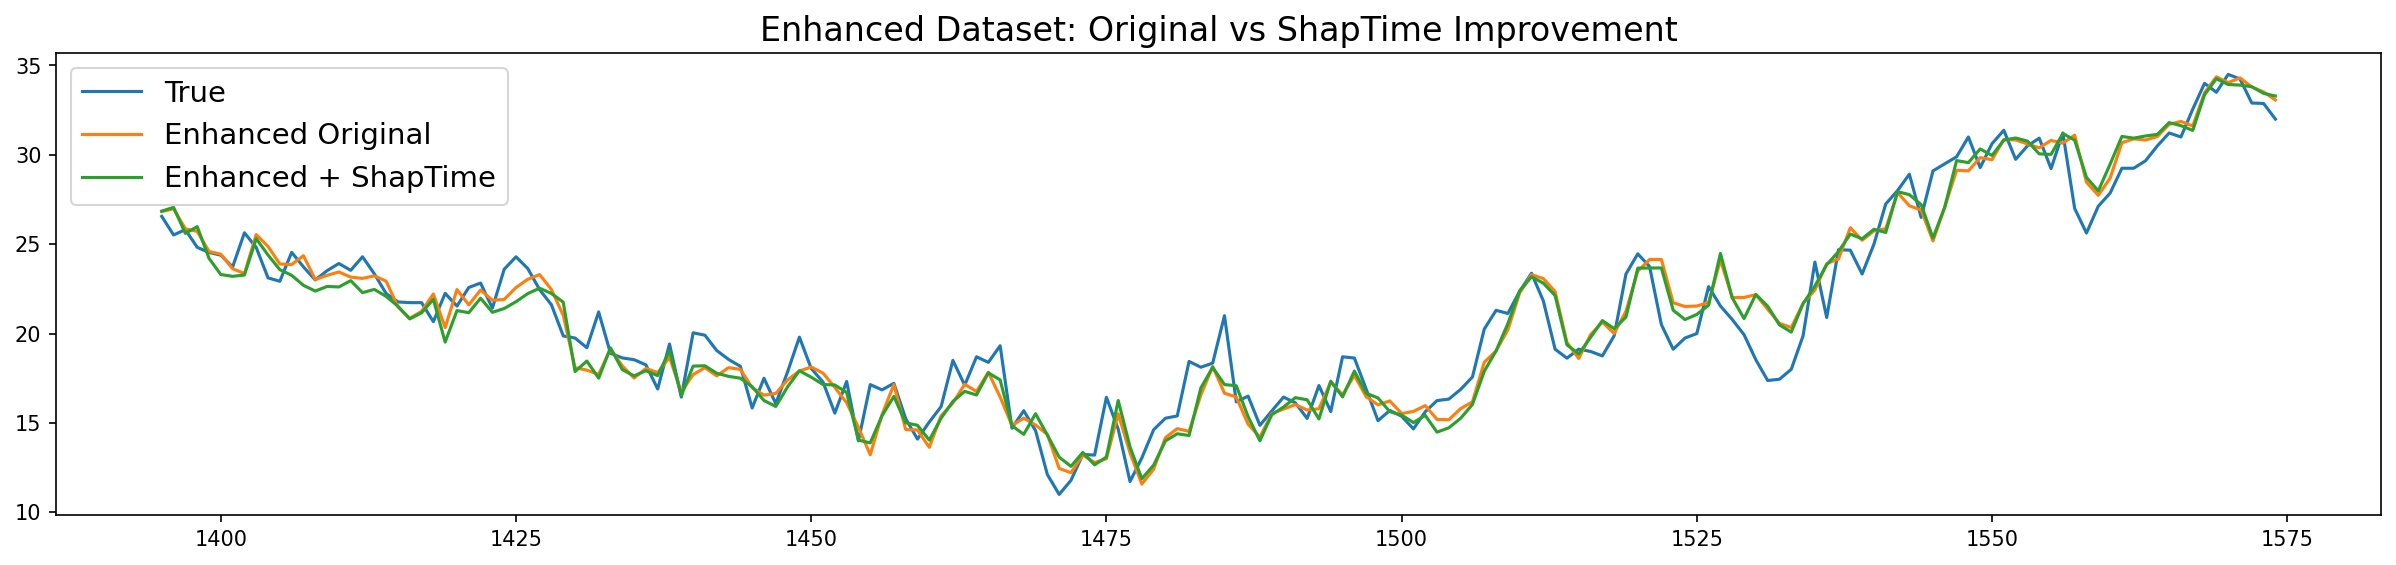

In [54]:
# Final comparison: Enhanced dataset results
pred_our_enh = pd.DataFrame(pred_check_enh, index=y_test_enh.index)

sns.reset_orig()
plt.figure(figsize = (20,4), dpi=150)

plt.plot(y_test_enh['meantemp'], label = 'True')
plt.plot(prediction_enh, label = 'Enhanced Original')
plt.plot(pred_our_enh, label = 'Enhanced + ShapTime')

plt.title('Enhanced Dataset: Original vs ShapTime Improvement', fontsize=16)
plt.legend(fontsize = 14)
plt.show()

# Final Comparison: All Models

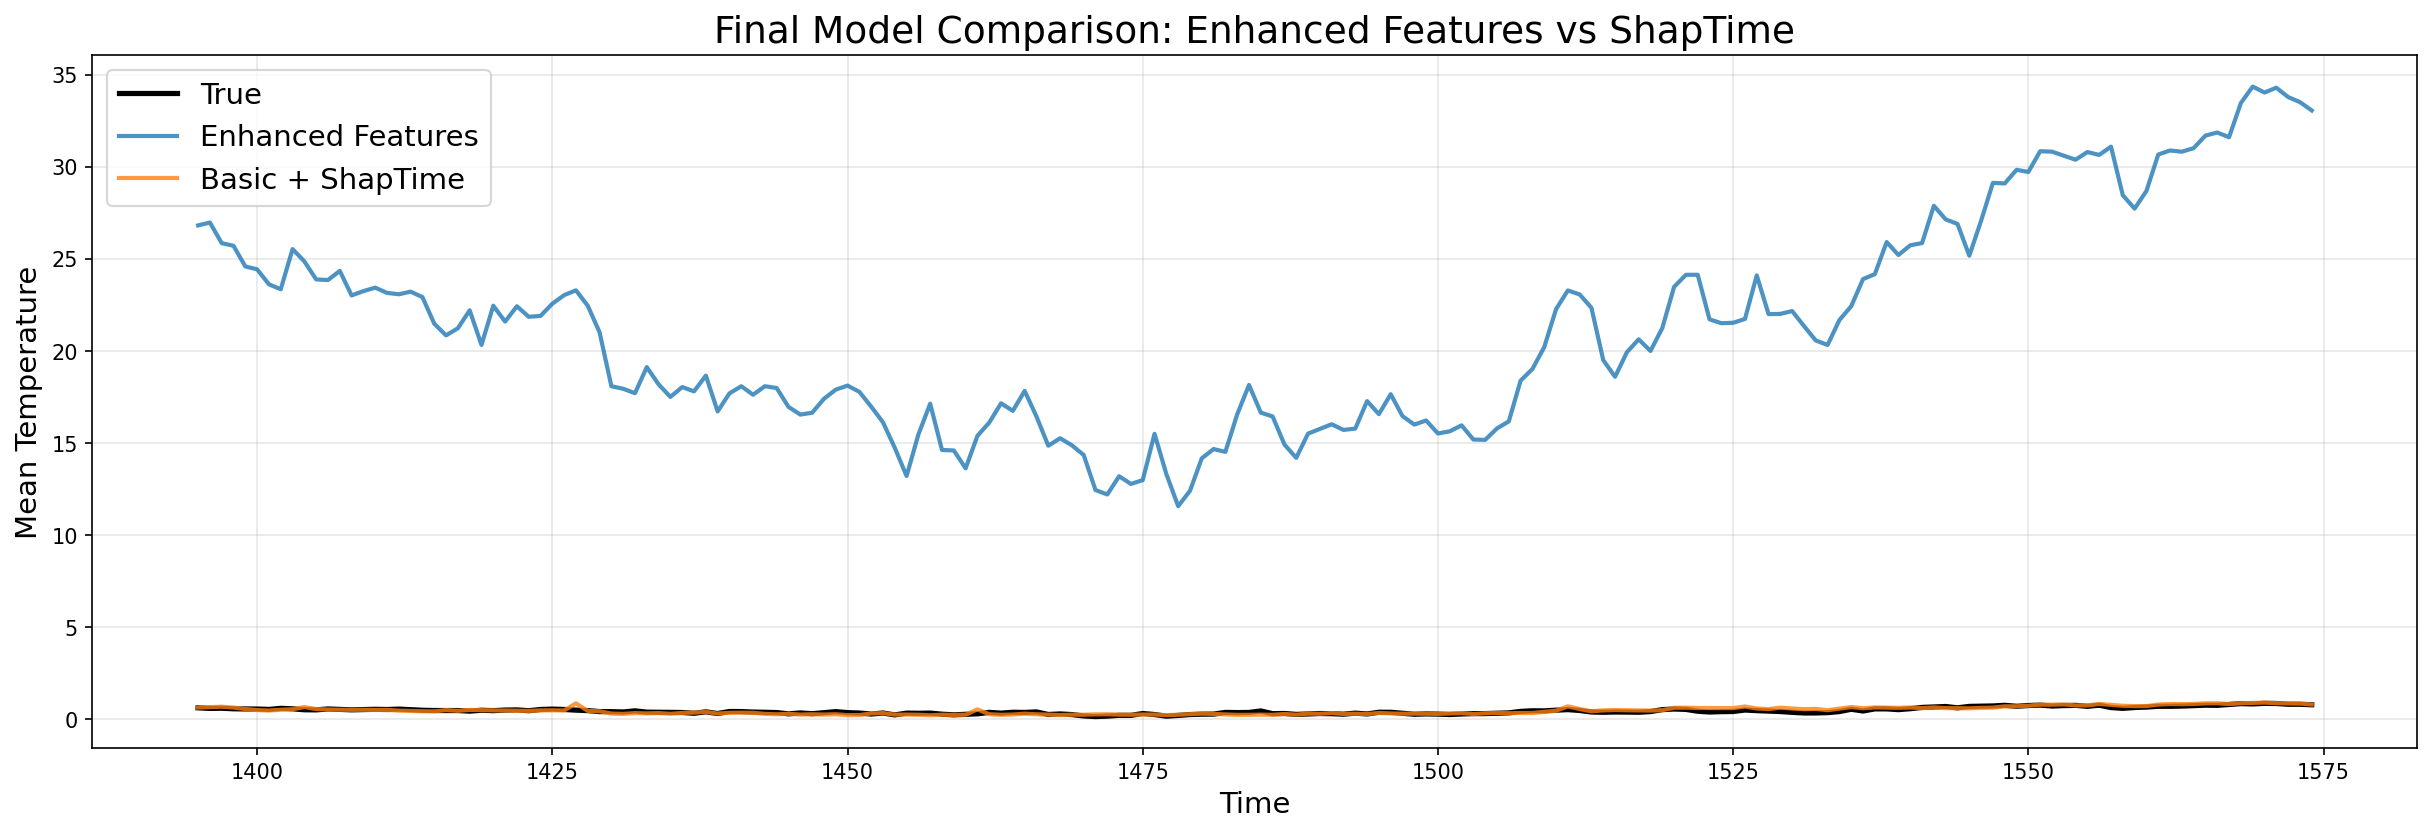

FINAL MODEL PERFORMANCE SUMMARY
Basic Features:           R² = 0.7814,      MSE = 0.008271
Enhanced Features:        R² = 0.9283,   MSE = 2.295934
Basic + ShapTime:         R² = 0.7848, MSE = 0.008233


In [55]:
# Ultimate comparison plot replacing "Original" with "Enhanced Original"
sns.reset_orig()
plt.figure(figsize = (20,6), dpi=150)

plt.plot(y_test['meantemp'], label = 'True', linewidth=2.5, color='black')
plt.plot(prediction_enh, label = 'Enhanced Features', linewidth=2, alpha=0.8)  # This replaces "Original"
plt.plot(pred_our, label = 'Basic + ShapTime', linewidth=2, alpha=0.8)

plt.title('Final Model Comparison: Enhanced Features vs ShapTime', fontsize=18)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Mean Temperature', fontsize=14)
plt.legend(fontsize = 14, loc='best')
plt.grid(True, alpha=0.3)
plt.show()

# Performance summary
print("="*60)
print("FINAL MODEL PERFORMANCE SUMMARY")
print("="*60)
print(f"Basic Features:           R² = {r2:.4f},      MSE = {mse:.6f}")
print(f"Enhanced Features:        R² = {r2_enh:.4f},   MSE = {mse_enh:.6f}")  
print(f"Basic + ShapTime:         R² = {r2_check:.4f}, MSE = {mse_check:.6f}")
print("="*60)